# DEMO: **Process Mining** with Python: **A Healthcare Application**  

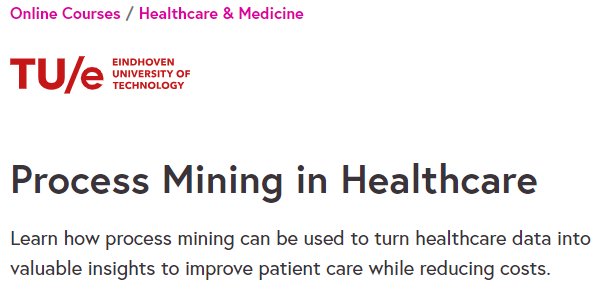

---   
Within healthcare there are thousands of complex and variable processes that generate data including treatment of patients, lab results and internal logistic processes. Analysing this data is vital for improving these processes and ending bottlenecks.

In recent years, digitisation of healthcare records and systemetisation of healthcare processes has resulted in the generation of more and more data from complex healthcare processes. There has also been growing interest in using process mining techniques to optimise and debug processes to improve the quality and efficiency of care. Such techniques have been used to:
   
+ **Discover processes and characterise them in process models**.  
Different graphical languages such as petri nets, directly-follows graphs and business process models might be used to represent such models.
+ Discover bottlenecks and **identifying opportunities for improving efficiency** by analysing throughput and the time spent on each event.
+ **Determine to what extent real processes adhere to those in good practice** guidelines and treatment pathways.  

<br>

---    
Data:
+ Data_ArtificialPatientTreatment.csv

---
Source:
+ [TU Eindhoven - Online Course "Process Mining in Healthcare"](https://www.futurelearn.com/courses/process-mining-healthcare)
+ [Medium - Process Mining with Python : A Healthcare Application](https://medium.com/@c3_62722/process-mining-with-python-tutorial-a-healthcare-application-part-1-ae02027a050)

+ [Eventlog Data@Gitlab](https://gitlab.com/healthcare2/process-mining-tutorial)  

---
History:   
+ 30.03.2023 v1 dbe --- initial version for BINA FS23  
+ 08.01.2024 v2 dbe --- minor corrections for CAS BPE16      
+ April 2024 v3 dbe --- minor corrections for BINA FS24   

---

## Load Libraries and Import (Event Log) Data

In [31]:
import pandas as pd
import numpy as np
from   datetime import date

from   IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
# a markdown formatted print output function printmd()
def printmd(string):
    display(Markdown(string))


In [33]:
logfilePATH = 'https://raw.githubusercontent.com/sawubona-repo/BINA-FS24-WORK/main/LB07-ProcessMining/Python/'
logfileNAME = 'Data_ArtificialPatientTreatment.csv'

eventlogFILE = logfilePATH + logfileNAME

In [34]:
# read event log data into a dataframe
events = pd.read_csv(eventlogFILE)

events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patient        690 non-null    object
 1    action        690 non-null    object
 2    org:resource  690 non-null    object
 3    DateTime      690 non-null    object
dtypes: object(4)
memory usage: 21.7+ KB


,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [35]:
#rename columns and set datetime type
events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])

In [36]:
print('Eventfile "{}" has {} rows and {} columns'.format(logfileNAME, events.shape[0], events.shape[1]))


Eventfile "Data_ArtificialPatientTreatment.csv" has 690 rows and 4 columns


---  
## Some **Feature Engineering**

In [37]:
# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case
case_starts_ends = events.pivot_table(index='patient', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']

# Merge with the main event log data so that for each row we have the start and end times
events = events.merge(case_starts_ends, on='patient')

# Calculate the relative time by subtracting the process start time from the event timestamp
events['relativetime'] = events['datetime'] - events['casestart']

# Convert relative times to more friendly measures
# Seconds:
events['relativetimes'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
# Days:
events['relativedays'] = events['relativetime'].dt.days

events.head()

,patient,action,resource,datetime,caseend,casestart,relativetime,relativetimes,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3


In [38]:
# remove leading and trailing blanks in the "action" and "resource" (string) values
events['action']   = events['action'].apply(lambda x: x.strip())
events['resource'] = events['resource'].apply(lambda x: x.strip())

events.head()

,patient,action,resource,datetime,caseend,casestart,relativetime,relativetimes,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3


In [39]:
# create new feature "action_sequence" and "numactions" for each row entry
delimiter = '___'

# make a single event string / count the no of actions for each patient
makeEventString = lambda x: delimiter.join(x)
makeEventString.__name__ = 'makeEventString'

numEvents = lambda x: len(x)
numEvents.__name__ = 'numEvents'


caselogs = events.pivot_table(index='patient', aggfunc={'action': [makeEventString, numEvents]})
caselogs = caselogs.reset_index()
caselogs.columns = ['patient', 'action_sequence', 'numactions']

events = pd.merge(events, caselogs, on='patient')
events['caselength'] = events['caseend'] - events['casestart']

events.head()


,patient,action,resource,datetime,caseend,casestart,relativetime,relativetimes,relativedays,action_sequence,numactions,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,First consult___Blood test___Physical test___S...,6,6 days 20:49:17


In [40]:
## Get day of week, hour of day and more
events['weekday']   = events['datetime'].apply(lambda x: x.weekday())
events['date']      = events['datetime'].apply(lambda x: x.date())
events['startdate'] = events['casestart'].apply(lambda x: x.date())
events['hour']      = events['datetime'].apply(lambda x: x.time().hour)

events.head()

,patient,action,resource,datetime,caseend,casestart,relativetime,relativetimes,relativedays,action_sequence,numactions,caselength,weekday,date,startdate,hour
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,16
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,3,2017-01-05,2017-01-02,13


---  
## **Questions** on Event Log Data

### a) What is the **minimum/maximum number of events per case**?

In [41]:
min_event_per_case = min(events['patient'].value_counts())
max_event_per_case = max(events['patient'].value_counts())

printmd('> **Minimum number of events per case**: {}'.format(min_event_per_case))
printmd('> **Maximum number of events per case**: {}'.format(max_event_per_case))

> **Minimum number of events per case**: 6

> **Maximum number of events per case**: 7

### b) What are the **patient Nr.26 consulations**?   
Which doctor did s/he have his/her consultation with?


In [42]:
xpat = 'patient 26'

first_doctor = events[events['datetime']==min(events[events['patient']==xpat]['datetime'])]['resource'].values[0]
last_doctor  = events[events['datetime']==max(events[events['patient']==xpat]['datetime'])]['resource'].values[0]

printmd('> **First doctor** consulting patient {}: **{}**'.format(xpat, first_doctor))
printmd('> **Last doctor** consulting patient {}: **{}**'.format(xpat,  last_doctor))

> **First doctor** consulting patient patient 26: **Dr. Bob**

> **Last doctor** consulting patient patient 26: **Dr. Ben**

### c) **List of activities**? **Activity with  lowest occurrence** in the event log?

In [44]:
activities = list(events['action'].unique())
markers    = ['*', '+', 'h', 'o', 'x', 'D', '^', 'v']
assert(len(activities)==len(markers))

printmd('> **List of activities**: {}'.format(activities))

> **List of activities**: ['First consult', 'Blood test', 'Physical test', 'Second consult', 'Surgery', 'Final consult', 'X-ray scan', 'Medicine']

In [43]:
lowest_activity_occurence = events['action'].value_counts().sort_values().idxmin()

printmd('> **Activity with lowest occurrence**: {}'.format(lowest_activity_occurence))

> **Activity with lowest occurrence**: Surgery

### d) **Selection of Patients** and their corresponding events?

In [78]:
patients = events['patient'].unique()

# select a subset of event data for the first x_patients in the list of all patients
x_patients = 50
selected_patients = patients[0:x_patients]

patientX = events[events['patient'].isin(selected_patients)]

printmd('> **No of selected patient events log**: {}'.format(patientX['patient'].count()))

> **No of selected patient events log**: 342

In [79]:
## Widget libraries
from ipywidgets import widgets
from ipywidgets import interact, interact_manual

patients = events['patient'].unique()

@interact
def getCaseData(x=patients):
    return events[events['patient']==x]



interactive(children=(Dropdown(description='x', options=('patient 0', 'patient 1', 'patient 2', 'patient 3', '…

### e) Most frequent **Event Sequence**

In [96]:
most_frequent_event = events['action_sequence'].value_counts().idxmax()


printmd('**The most frequent event (sequence) has** {} **activities.**'.format(len(most_frequent_event.split(delimiter))))
printmd('**The activity sequence is**:  {}.'.format(', '.join(most_frequent_event.split(delimiter))))

**The most frequent event (sequence) has** 7 **activities.**

**The activity sequence is**:  First consult, Blood test, X-ray scan, Physical test, Second consult, Medicine, Final consult.

---
## **Visualizations** of Event Log Data

In [86]:
# set sns overall figure size
sns.set(rc={'figure.figsize':(12, 8)})

### a) Discrete Event Plot / Scatter Plot
* y-axis represents each patient case.
* x-axis represents time since case was initiated.
* Different marker shapes represent different types of cases.

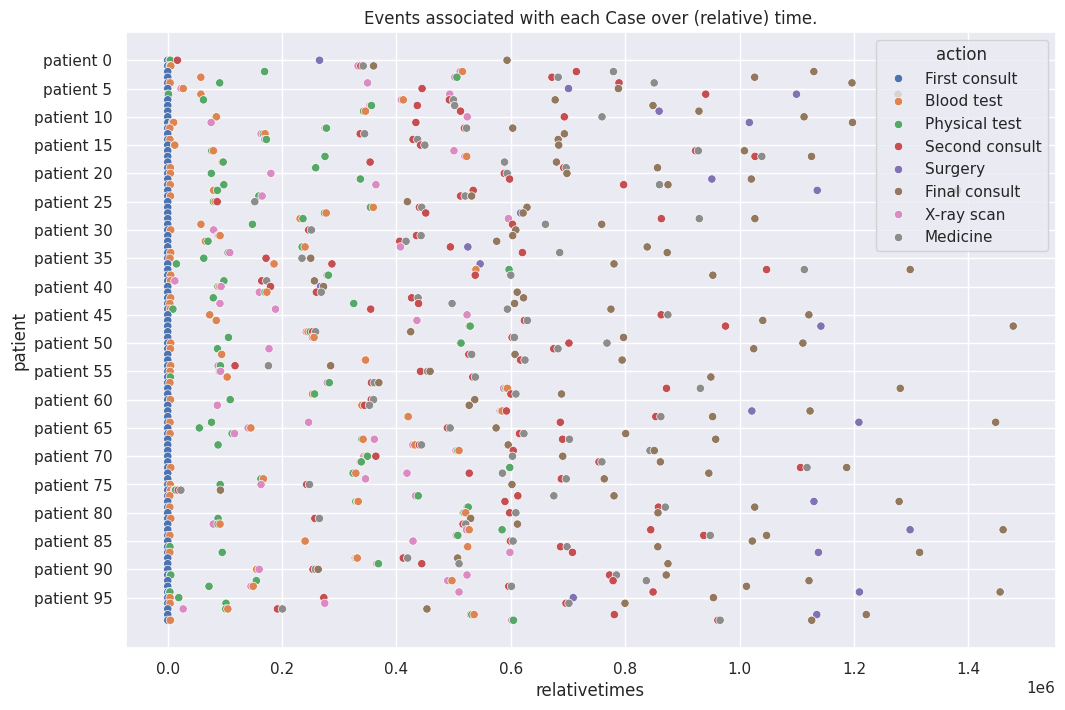

In [91]:
## Get an array of patient labels for the y axis - for graph labelling purposes
patientnums = [int(e) for e in events['patient'].apply(lambda x: x.strip('patient'))]

# Plot a scatter plot of patient events over relative time
ax = sns.scatterplot(x=events['relativetimes'],
                     y=events['patient'],
                     hue=events['action']);

# Set plot title
plt.title('Events associated with each Case over (relative) time.');

# Set y axis ticks so that you only show every 5th patient - for readability
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

plt.show()

> This is quite difficult to read. To make the plot easier to read, we should *order the cases by overall process lengths*.   
 This also gives you a better feel for the **distribution of process durations**.

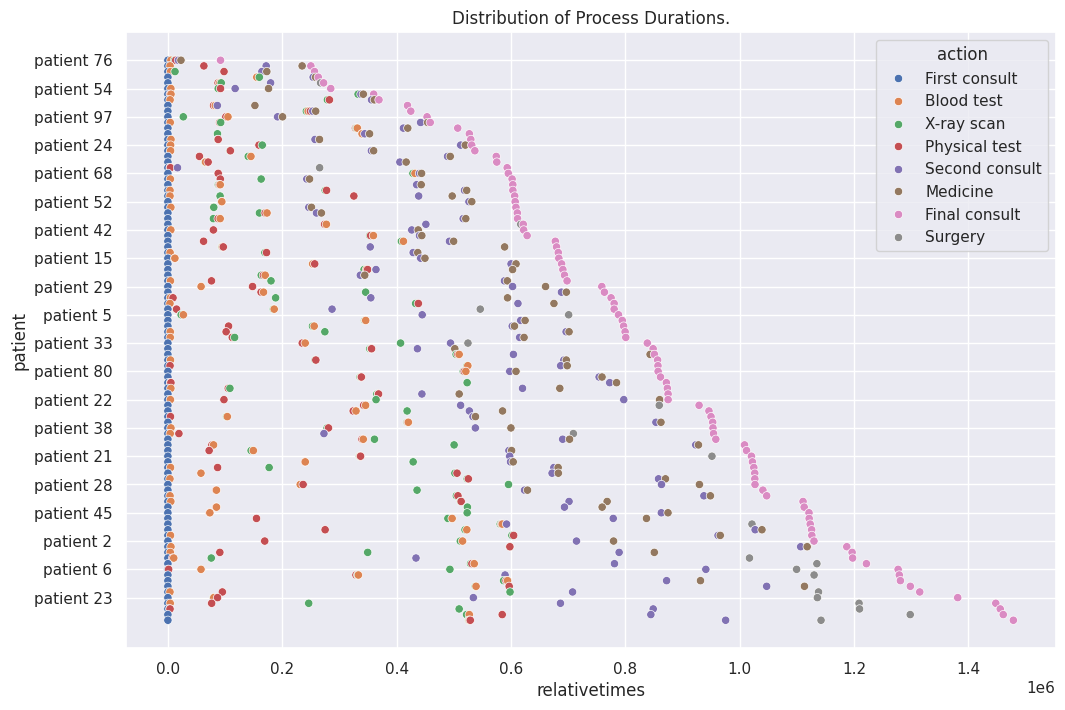

In [92]:
## Order by the Case length
ordered = events.sort_values(by=['caselength', 'patient', 'relativetimes'])

# Ordered dotted chart of event occurrences within each case (patient)
ax = sns.scatterplot(x=ordered['relativetimes'],
                     y=ordered['patient'],
                     hue=ordered['action'])

# Set plot title
plt.title('Distribution of Process Durations.');

plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

plt.show()

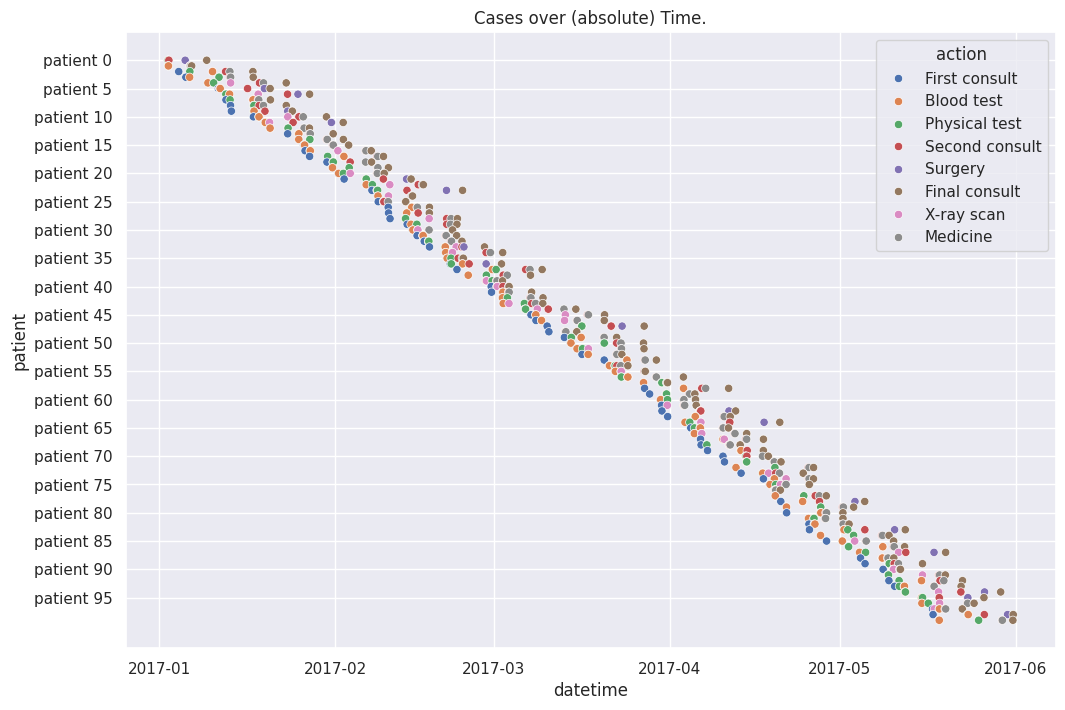

In [93]:
# The dotted chart can also be used to get an idea of the event flow over absolute time
ax = sns.scatterplot(x=events['datetime'],
                     y=events['patient'],
                     hue=events['action'])

# Set plot title
plt.title('Cases over (absolute) Time.');

plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

plt.show()

> This shows a steady flow of cases over time.

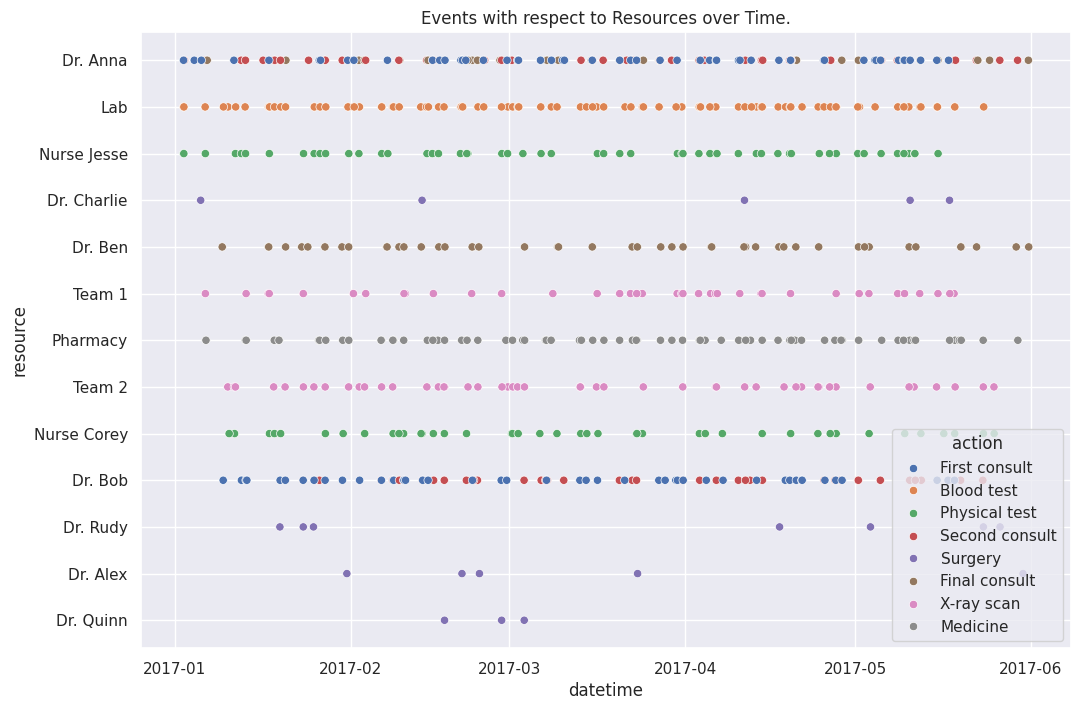

In [94]:
# You can also study events with respect to the resources by plotting events with respect to them.
ax = sns.scatterplot(x=events['datetime'],
                     y=events['resource'],
                     hue=events['action'])

# Set plot title
plt.title('Events with respect to Resources over Time.');

plt.show()

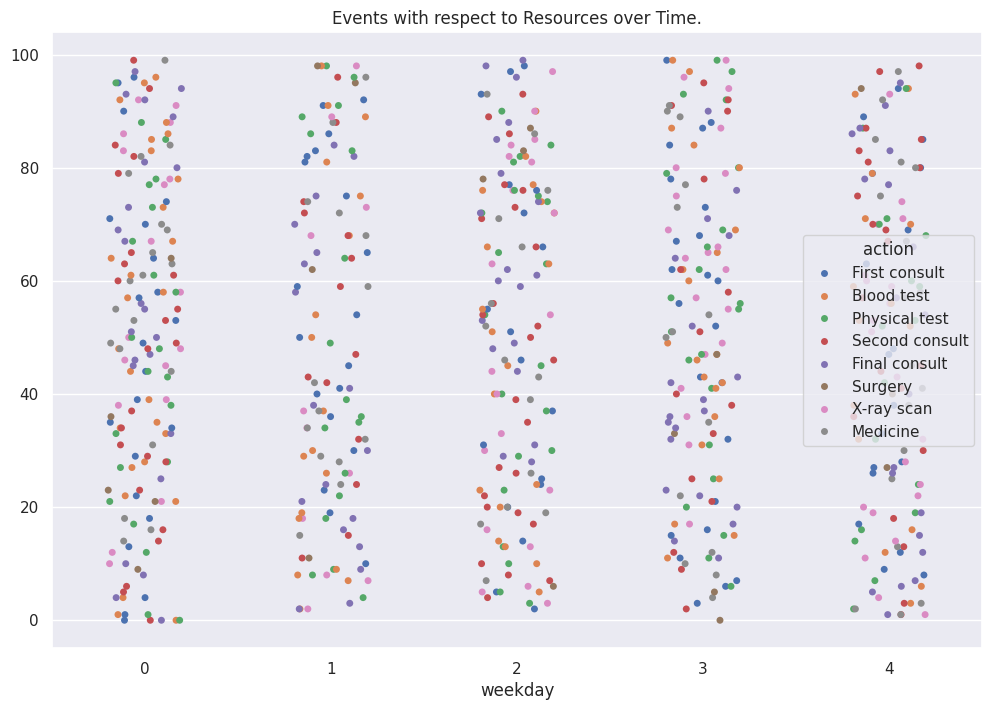

In [95]:
## Strip plot
ax = sns.stripplot(x=events['weekday'],
                   y=patientnums,
                   hue=events['action'],
                   jitter=0.2)

# Set plot title
plt.title('Cases over Days of the Week.');

plt.show()

### b) Filtering Events   

One final thing you might want to look at is which events are shared by all processes and which are not, **since in process mining it is the non-shared differentiating events** that we are interested in

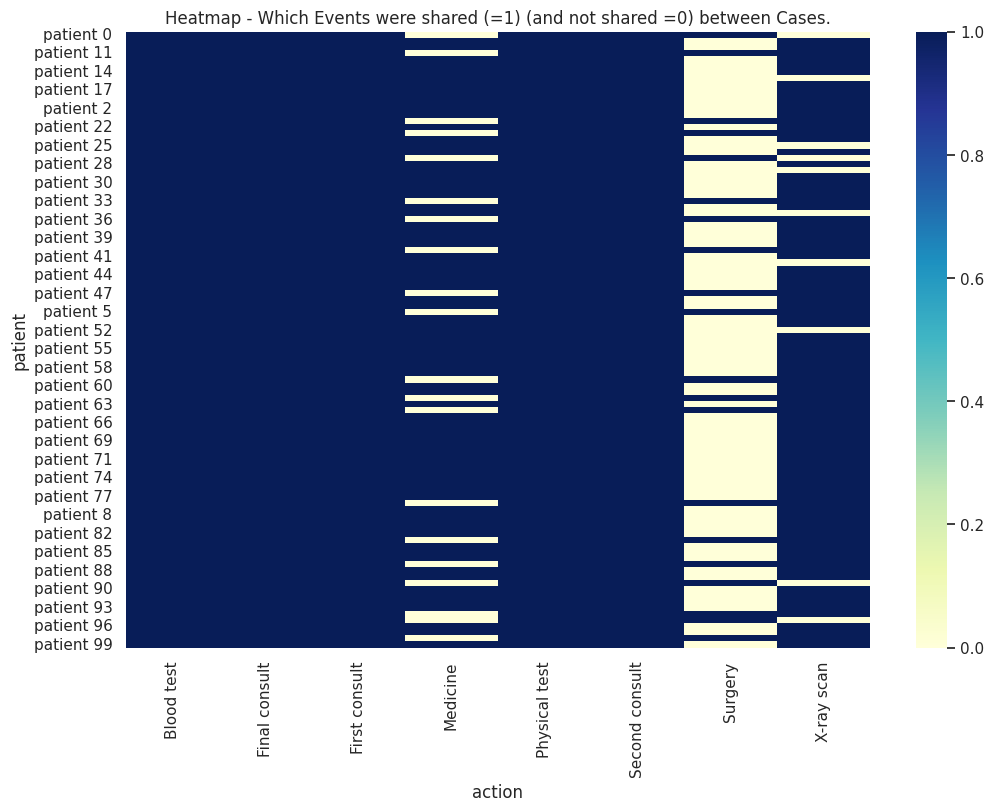

In [100]:
## Create a table giving the number of cases in which each event is present.
patient_events = pd.crosstab(events['patient'], events['action'])

# Visualise which events are common to patients

sns.heatmap(patient_events,
            cmap="YlGnBu")

# Set plot title
plt.title('Heatmap - Which Events were shared (=1) (and not shared =0) between Cases.');

plt.show()

In [97]:
# Calculate the number of unique event counts
# This should be 1 for events which are shared by all patients.
nunique = patient_events.apply(pd.Series.nunique)

# Identify the events which are shared by all
shared_actions = nunique[nunique==1].index
actions_to_keep = nunique[nunique>1].index

printmd('**The following actions are common to all cases**: {}'.format(', '.join(shared_actions)))
printmd('**The following actions are the ones that we wish to keep (not common to all cases)**: {}'.format(', '.join(actions_to_keep)))

**The following actions are common to all cases**: Blood test, Final consult, First consult, Physical test, Second consult

**The following actions are the ones that we wish to keep (not common to all cases)**: Medicine, Surgery, X-ray scan

> In this example, First consult, Blood test, Second consult, Physical test and Final consult are the events shared by all patients,   
 while Medicine, Surgery and X-ray scan are the differentiating events.

---
## Process Mining  

* Check out this [introduction to process mining in Python](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5).
* [Documentation for pm4py](https://pm4py.fit.fraunhofer.de/)

In [ ]:
!pip install pm4py
import pm4py

In [51]:
pip --version

pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [121]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.petri_net.util import performance_map
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# misc
from pm4py.objects.conversion.process_tree import converter as pt_converter


Referring back to the [DEMO_Python_PM4PY_ProcessDiscovery.ipynb](https://github.com/sawubona-repo/BINA-FS24-WORK/blob/195f9d41127f8199d9ba46f130f36f241afe7506/LB07-ProcessMining/Python/DEMO_Python_PM4PY_ProcessDiscovery.ipynb) notebook, we want to map:

+ the *patient* column to **case**, which for pm4py is the ‘case:concept:name’ label;
+ the *datetime* column to **timestamp**, which for pm4py is the *time:timestamp* label;
+ the *action* column as the **event**, which for pm4py is the *concept:name* and
+ the *resource* column to **resource**, which for pm4py is the *org:resource* label.

In [102]:
## Specify which columns correspond to case (case:concept:name),
## event (concept:name) and timestamp (time:timestamp) - rename columns in accordance with pm4py
eventlog = events.copy()

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

eventlog.head()

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetimes,relativedays,action_sequence,numactions,caselength,weekday,date,startdate,hour
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,16
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,3,2017-01-05,2017-01-02,13


Then we use the `log_converter` object to convert it into the **log format** that pm4py recognises.

In [104]:
## Convert to log format
log = log_converter.apply(eventlog)

log[0]

{'attributes': {'concept:name': 'patient 0'}, 'events': [{'concept:name': 'First consult', 'org:resource': 'Dr. Anna', 'time:timestamp': Timestamp('2017-01-02 11:40:11'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('0 days 00:00:00'), 'relativetimes': 0, 'relativedays': 0, 'action_sequence': 'First consult___Blood test___Physical test___Second consult___Surgery___Final consult', 'numactions': 6, 'caselength': Timedelta('6 days 20:49:17'), 'weekday': 0, 'date': datetime.date(2017, 1, 2), 'startdate': datetime.date(2017, 1, 2), 'hour': 11}, '..', {'concept:name': 'Final consult', 'org:resource': 'Dr. Ben', 'time:timestamp': Timestamp('2017-01-09 08:29:28'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('6 days 20:49:17'), 'relativetimes': 593357, 'relativedays': 6, 'action_sequence': 'First consult___Blood test___Physical test___Second consult_

### a) **Alpha Miner** for process discovery

Alpha miner is one of the most best-known process mining algorithms, and one of the first algorithms that could discover concurrency. The algorithm uses the *direct succession*, *causal*, *parallel*, and *unrelated* relationships between transitions in the log to discover a **workflow net**.  
[This page](http://mlwiki.org/index.php/Alpha_Algorithm) gives you a more thorough account of the algorithm and formal definitions of the relationships between transitions.

> **Alpha miner can be implemented very easily with the pm4py by importing the algorithm and applying it to the event log.**

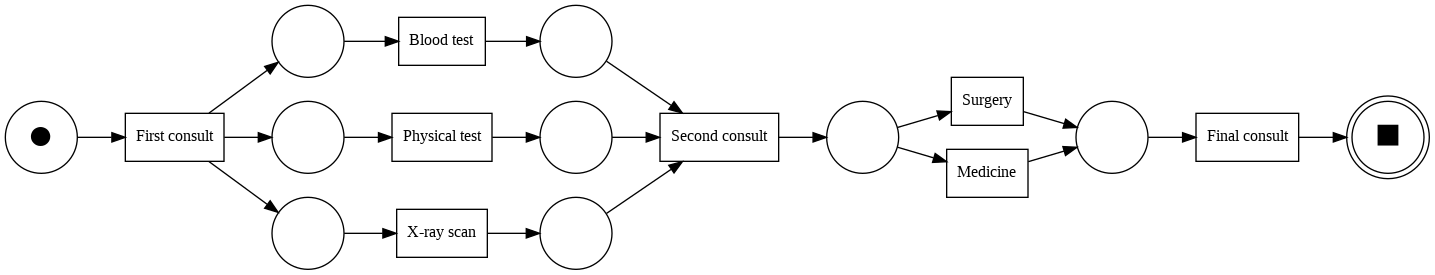

''

In [110]:
# apply Alpha miner to log data
net, initial_marking, final_marking = alpha_miner.apply(log)

# Visualize the petri net of the discovered process
gviz = pn_visualizer.apply(net,
                           initial_marking,
                           final_marking)

pn_visualizer.view(gviz)

# and save the Petri net diagram
pn_visualizer.save(gviz, "Plot_AlphaMiner_Healthcare_Petrinet1.png")

> You will notice that alpha miner has retained the ordering information so that Blood test, Physical test, and X-ray occur after First consult and before Second consult, and Medicine and Surgery occur after Second consult and before Final consult.

To get an idea of the frequencies of the transitions, you can label the transitions by setting the variant parameter to `pn_visualizer.Variants.FREQUENCY` when calling `pn_visualizer.apply()`

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

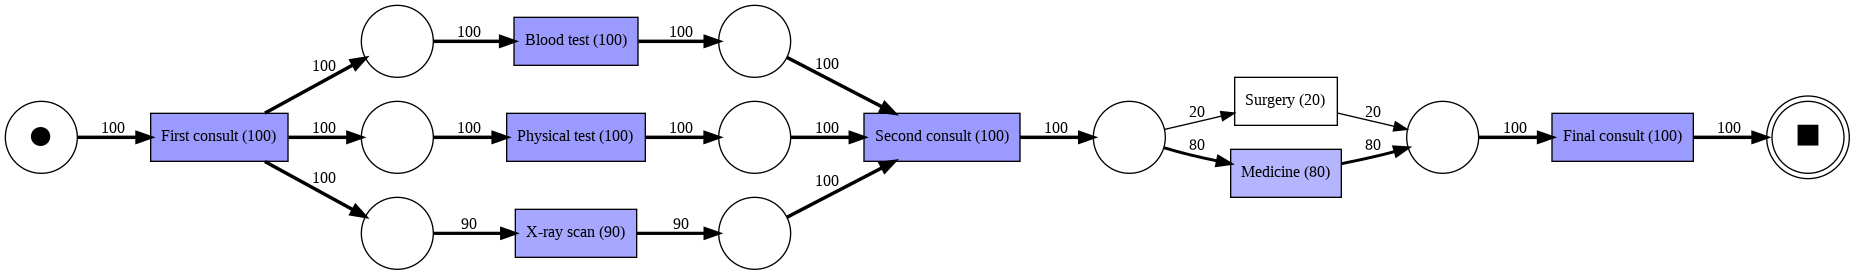

''

In [114]:
# add information about "frequency" to the visualization
gviz = pn_visualizer.apply(net,
                           initial_marking,
                           final_marking,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log);

pn_visualizer.view(gviz);

# and save the Petri net diagram
pn_visualizer.save(gviz, "Plot_AlphaMiner_Healthcare_Petrinet2.png")

### b) **Directly-follows Graph** (DFG) for discovering the process graph  

b1) A DFG with total cases between nodes (**frequency**)

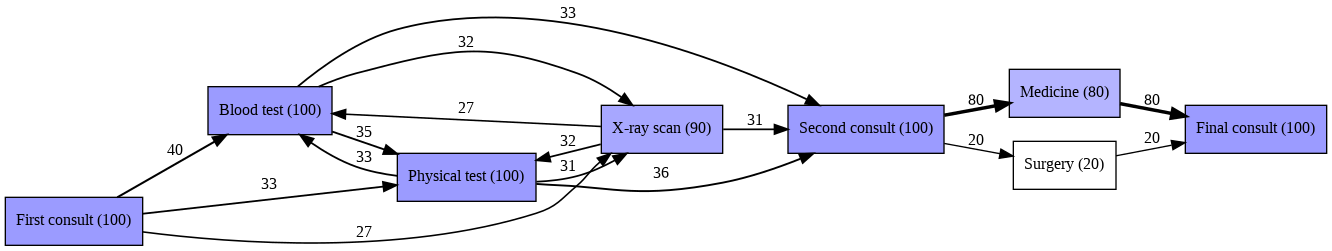

''

In [123]:
# Create DFG graph from log
dfg = dfg_discovery.apply(log)

# visualize the dfg graph
gviz = dfg_visualizer.apply(dfg,
                               log=log,
                               variant=dfg_visualizer.Variants.FREQUENCY)

dfg_visualizer.view(gviz)

# and save the DFG diagram
dfg_visualizer.save(gviz, "Plot_DFG_Healthcare_FREQUENCY.png")

b2) A DFG with average times between nodes (**performance**)

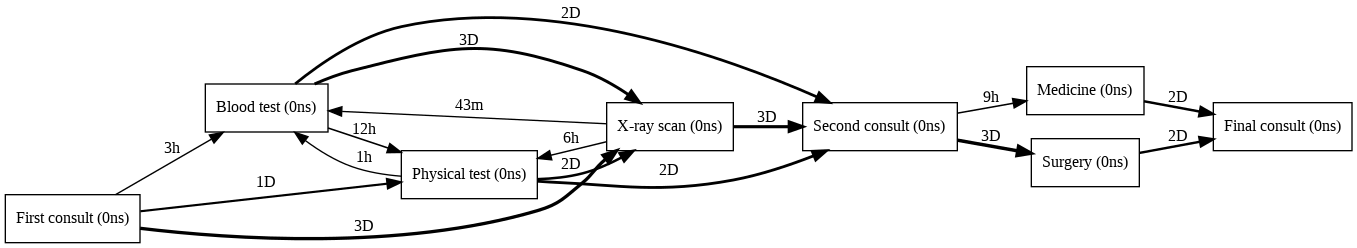

''

In [124]:
# Create DFG the graph from log
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

# visualize the dfg graph
gviz = dfg_visualizer.apply(dfg, log=log, variant=dfg_visualizer.Variants.PERFORMANCE)

dfg_visualizer.view(gviz)

# and save the DFG diagram
dfg_visualizer.save(gviz, "Plot_DFG_Healthcare_PERFORMANCE.png")

### c) Use **Heuristic Miner** for discovering the process tree

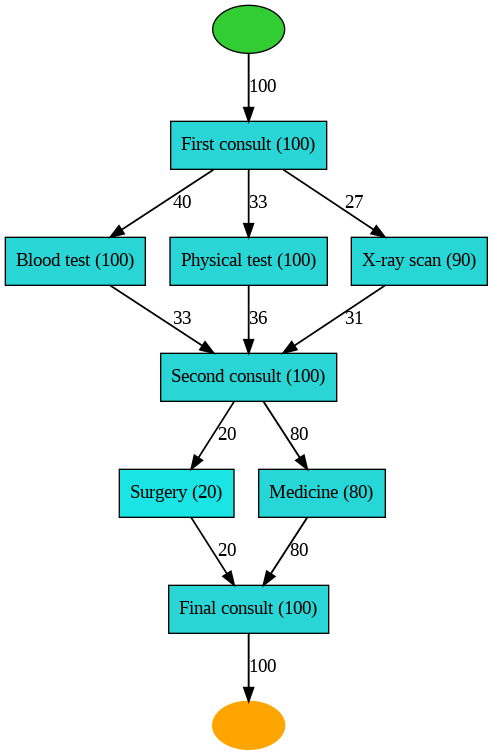

''

In [125]:
# heuristics miner
heu_net = heuristics_miner.apply_heu(log)

# visualize the process tree
gviz = hn_visualizer.apply(heu_net)

hn_visualizer.view(gviz)

# and save the Process Tree diagram
hn_visualizer.save(gviz, "Plot_HeuristicMiner_Healthcare_ProcessTree.png")